In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, InputLayer, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
data_csv = "../data/dataset.csv"
df = pd.read_csv(data_csv)
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (1176, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-14,12.4000,12.40,12.26,12.4000,12.4000,74938.0
1,2019-08-15,12.3800,12.47,12.38,12.4000,12.4000,18754.0
2,2019-08-18,12.4000,12.50,12.50,12.5000,12.5000,2332.0
3,2019-08-19,12.5000,12.48,12.35,12.3746,12.3746,23745.0
4,2019-08-20,12.3746,12.37,12.33,12.3300,12.3300,212351.0


In [3]:
# Verifying null values and deleting name from dataset
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()
# Drop Date column
# df.pop("Date")

print('Dataset shape: ', df.shape)

     Open  High  Low  Close  Adj Close  Volume
72    NaN   NaN  NaN    NaN        NaN     NaN
457   NaN   NaN  NaN    NaN        NaN     NaN
467   NaN   NaN  NaN    NaN        NaN     NaN
501   NaN   NaN  NaN    NaN        NaN     NaN
513   NaN   NaN  NaN    NaN        NaN     NaN
Dataset shape:  (1144, 7)


In [4]:
print("Minimum: {}\nMaximum: {}\nMean: {}\nMedian: {}\nSD: {}\nSkewness: {}\nKurtosis: {}".format(df["Low"].min(), df["High"].max(), 
df["Open"].mean(), df["Open"].median(), df["Open"].std(), df["Open"].skew(), df["Open"].kurtosis()))

Minimum: 11.65
Maximum: 19.941999
Mean: 14.230973513111886
Median: 13.8269
SD: 1.6454705048232097
Skewness: 1.0012988186754024
Kurtosis: 0.6677055658188862


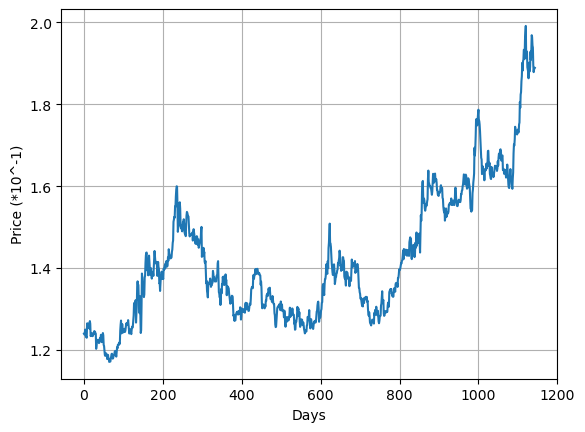

In [5]:
lastday_2017 = df.loc[df["Date"]=="2023-05-30"].index.values[0]
df = df["Open"].values


plt.figure()
plt.plot(df/10)
plt.xlabel("Days")
plt.ylabel("Price (*10^-1)")
plt.grid()
plt.show()

In [6]:
# Transforming the dataset to ln scale
df = np.log(df)

# # Split dataset into train and test
train_set = df[0:lastday_2017]
test_set = df[lastday_2017:]
print("Train: ", train_set.shape, "Test: ", test_set.shape)
lastday_2017

Train:  (925,) Test:  (219,)


925

In [7]:
lastday_2017

925

## Labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the next day gold price closing value, this way a matrix of 2 dimensions will suffice for this problem.

# Regression models

In [8]:
# FFNN class
class FFNN:
    def __init__(self, input_dim, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        h_n = 3 if input_dim == 4 or input_dim == 6 else 5
        self.model = Sequential()
        self.model.add(Dense(h_n, input_dim=input_dim))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
        self.model.fit(x_train, y_train,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [9]:
# LSTM class
class PLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type in [1,3,4] else 200
        return_seq = True if model_type>2 else False
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1], 1), return_sequences=return_seq))
        if model_type>2:
            self.h_n2 = 50 if model_type == 3 else 100
            self.model.add(LSTM(units=self.h_n2))
            if type==4:
                self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)

        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        history = self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0)

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [10]:
# CNN-LSTM class
class CNNLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type == 1 else 200
        self.filter1 = 32 if model_type == 1 else 64
        self.filter2 = 64 if model_type == 1 else 128
        
        self.model.add(Conv1D(self.filter1, 2,activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=(input_shape[1],
                                   1)))

        self.model.add(Conv1D(self.filter2, 2,
                   activation='relu',
                   strides=1,
                   padding='same',
                   input_shape=(input_shape[1],
                                1)))

        self.model.add(MaxPooling1D(pool_size=2, padding='valid'))
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1],1), ))
        if type==3:
            self.model.add(Dropout(0.2))  # 添加dropout层，dropout率0.2

        if type==2:
            self.model.add(Dense(32), activation='relu')

        
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
            
        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [11]:
def create_models(entry_shape, scaler=None):
    # # SVR
    # svr = SVR(kernel='rbf', C=1, tol=1e-3)

    # # FFNN
    # ffnn = FFNN(entry_shape[1], scaler)

    # # LSTM1
    # lstm1 = PLSTM(entry_shape, 1, scaler)

    # # LSTM2
    # lstm2 = PLSTM(entry_shape, 2, scaler)

    # # LSTM3
    # lstm3 = PLSTM(entry_shape, 3, scaler)

    # # LSTM4
    # lstm4 = PLSTM(entry_shape, 4, scaler)

    # CNN-LSTM1
    cnnlstm1 = CNNLSTM(entry_shape, 1, scaler)

    # CNN-LSTM2
    cnnlstm2 = CNNLSTM(entry_shape, 2, scaler)

    # CNN-LSTM3
    cnnlstm3 = CNNLSTM(entry_shape, 3, scaler)

    labels = ["CNN-LSTM1", "CNN-LSTM2", "CNN-LSTM3"]
    models = [cnnlstm1, cnnlstm2, cnnlstm3]

    return labels, models

## Rolling window approach
The paper states that in order to predict the next day gold price, the model uses the $n$ past days gold prince, where $n$ stands for the time horizon used. Thus to generate a dataset with this specifications, we will use a rolling window algorithm to generate a window of features to a window of labels ( with in this case is equal to 1). This rolling window procedure works as follows:

Features: $[n1, n2, n3, n4, n5]$ -> Label $[n6]$

In [12]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [13]:
def generate_feat_labels_per_horizon(time_horizon, df, verbose=False):

    # Get the feature and label to the prediction task 
    feature_mtx = rolling_window_mtx(df, time_horizon)[:-1]
    label_mtx   = rolling_window_mtx(df[time_horizon:], 1)
    index_mtx   = rolling_window_mtx(np.arange(len(df)), time_horizon)

    if verbose:
        # Now we have a set of windows of the real coordinate
        # Lets take a look in one window
        print(f"\n One feature window: \n {feature_mtx[0]}")
        print(f"\n One label window: \n {label_mtx[0]}")
        print(f"\n Original dataset: \n {df[0:5]}")

    # For the classification task (if the gold values goes up or down)
    # We need to get a window of size 2, and then calculate the difference
    # If positive, the gold value went up.
    class_label_mtx = rolling_window_mtx(df[time_horizon-1:], 2)
    func = lambda x: True if x > 0 else False
    class_func = np.vectorize(func)
    class_label_mtx = class_func(np.diff(class_label_mtx).flatten()).reshape(len(class_label_mtx),1)
   
    if verbose:
    
        print(f"\n One window of class label (If tomorrow price is larger than today's price): \n {class_label_mtx[0]}")
    
    return feature_mtx, label_mtx, class_label_mtx

In [14]:
label_index_mtx = rolling_window_mtx(np.arange(len(df))[4:], 1)
index_mtx   = rolling_window_mtx(np.arange(len(df)), 4)[:-1]

In [15]:
train_idx = lastday_2017 - 4
index_mtx[train_idx], label_index_mtx[train_idx]

(array([921, 922, 923, 924]), array([925]))

## Normalizing dataset

In [16]:
df = df.reshape(len(df),1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df = df.flatten()
df

array([2.51769647, 2.51608227, 2.51769647, ..., 2.93757341, 2.93745152,
       2.93855851])

In [17]:
entries = [6]
models = []
labels = []
for entry in entries:
    #Creating dataset
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    scaler_output.fit(label_mtx)
    train_idx = lastday_2017 - entry
    train_x = feature_mtx[:train_idx]
    train_y = label_mtx[:train_idx]
    tmp_labels, tmp_models = create_models(train_x.shape)#, scaler)
    for i in range(len(tmp_models)):
        print(tmp_labels[i])
        tmp_models[i].fit(train_x, train_y)
    models.append(tmp_models)
    labels.append(tmp_labels)

CNN-LSTM1
CNN-LSTM2
CNN-LSTM3


In [18]:
models = np.ravel(models)
labels = np.ravel(labels)
print(len(models))

3


In [19]:
def classification_pred(y):
    preds = []
    for i in range(1, len(y)):
        last_y = y[i - 1]
        curr_y = y[i]
        preds.append(curr_y - last_y > 0.0 )
    return np.array(preds)

# Metric functions
def get_metrics(y, pred_y):
    y_classification = classification_pred(y)
    y_pred_classification = classification_pred(pred_y)
    
    fpr, tpr, thresholds = roc_curve(y_classification, y_pred_classification)
    auc_value = auc(fpr, tpr)

    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_classification)):
        is_y_pred_up = y_pred_classification[i]
        is_y_up = y_classification[i][0]

        if is_y_pred_up and is_y_up:
            tp += 1
        elif is_y_pred_up and not is_y_up:
            fp += 1
        elif not is_y_pred_up and not is_y_up:
            tn += 1
        else:
            fn += 1

    return tp, tn, fp, fn, auc_value

In [20]:
# Testing models
index_model = 0
for entry in entries:
    print ("# Entries: ", entry)
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    train_idx = lastday_2017 - entry
    test_x = feature_mtx[train_idx:]
    test_y = label_mtx[train_idx:]
    
    model_list = []
    MAE_list = []
    RMSE_list = []
    ACC_list = []
    AUC_list = []
    SEN_list = []
    SPE_list = []
    
    # indwx_model + len(models)
    for i in range(index_model, index_model+3):
        test_y_estimative = models[i].predict(test_x)
        tp, tn, fp, fn, auc_value = get_metrics(test_y, test_y_estimative)
        
        print("\nClassifier type: ", labels[i])
        print("MAE = ", mean_absolute_error(test_y, test_y_estimative))
        print("RMSE = ", mean_squared_error(test_y, test_y_estimative, squared=True))
        print("ACC = ", (tp + tn) / (tp + tn + fp + fn))
        print("AUC = ", auc_value)
        print("SEN = ", tp / (tp + fn))
        print("SPE = ", tn / (tn + fp))
        print("TP = ", tp)
        print("TN = ", tn)
        print("FP = ", fp)
        print("FN = ", fn)
        
        model_list.append(labels[i])
        MAE_list.append(mean_absolute_error(test_y, test_y_estimative))
        RMSE_list.append(mean_squared_error(test_y, test_y_estimative, squared=True))
        ACC_list.append(((tp + tn) / (tp + tn + fp + fn))*100)
        AUC_list.append(auc_value)
        SEN_list.append(tp / (tp + fn))
        SPE_list.append(tn / (tn + fp))
        
    df_print = pd.DataFrame(list(zip(model_list, MAE_list,RMSE_list,ACC_list,AUC_list,SEN_list, SPE_list)),
           columns =['Model', 'MAE', 'RMSE', 'ACC (%)', 'AUC', 'SPEN', 'SPE'])
    df_print.style
    display(df_print)
        
    index_model += 3

# Entries:  6
7/7 [==============================] - 1s 4ms/step

Classifier type:  CNN-LSTM1
MAE =  0.04997062799127149
RMSE =  0.0029802739727567197
ACC =  0.5321100917431193
AUC =  0.5281713900134953
SEN =  0.6140350877192983
SPE =  0.4423076923076923
TP =  70
TN =  46
FP =  58
FN =  44


f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7/7 [==============================] - 1s 7ms/step

Classifier type:  CNN-LSTM2
MAE =  0.053951595543421715
RMSE =  0.0034153836021775658
ACC =  0.5412844036697247
AUC =  0.5382085020242915
SEN =  0.6052631578947368
SPE =  0.47115384615384615
TP =  69
TN =  49
FP =  55
FN =  45


f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7/7 [==============================] - 1s 7ms/step

Classifier type:  CNN-LSTM3
MAE =  0.06145470661193827
RMSE =  0.004373756556970926
ACC =  0.5321100917431193
AUC =  0.5290148448043185
SEN =  0.5964912280701754
SPE =  0.46153846153846156
TP =  68
TN =  48
FP =  56
FN =  46


f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
f:\develop\miniconda3\envs\env_DeepLearning_PyTorch-1.13.1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,CNN-LSTM1,0.049971,0.002980,53.211009,0.528171,0.614035,0.442308
1,CNN-LSTM2,0.053952,0.003415,54.128440,0.538209,0.605263,0.471154
2,CNN-LSTM3,0.061455,0.004374,53.211009,0.529015,0.596491,0.461538
